In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

# RBF (Radial Basis Functions) pentru regresie



##  Setul de date

Sunt alese aleator 100 de puncte între $[0, 1)$, şi construim o 'sinusoidă' perturbată pentru punctele astfel alese:

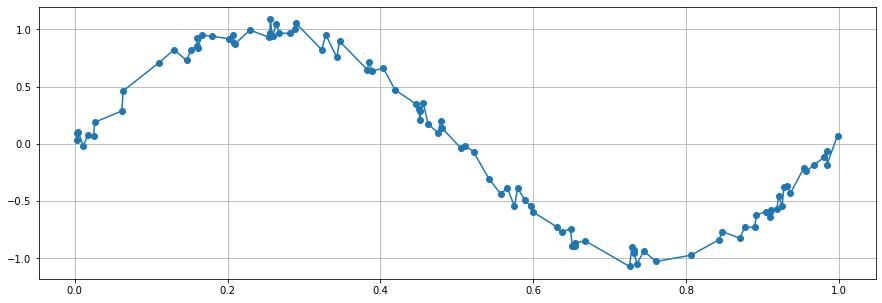

In [2]:
samples = 100
x = np.random.uniform(low=0.0, high=1.0, size=samples)
x = np.sort(x, axis=0)

noise = np.random.uniform(low=-0.1, high=0.1, size=samples)
y = np.sin(2 * np.pi * x)  + noise
 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

## Algoritmul K-means

K-means este folosit pentru construcţia centroizilor. Acolo vom 'centra' cele K gaussiene.

1. se aleg cei K centri aleator dintre cele 100 de puncte existente
2. calculează distanţa de la fiecare punct la fiecare dintre cei K centroizi
3. pentru fiecare punct, se găseşte cel mai apropiat centroid de punctul respectiv
4. pentru fiecare din cei K centroizi, se recalculează media cluster-ului ca fiind media punctelor celor mai apropiate de acel centroid
5. centroidul devine media astfel calculată
6. repetă paşii 2 - 5 până când centroizii au o deplasare sub $10^{-6}$

Algoritmul K-means va întoarce centroizii împreună cu deviaţia standard a fiecărui cluster, asociat acelui centroid.

Dacă există clustere cu mai puţin de doi reprezentanţi, deviaţia standard ($\sigma$) a acelui cluster va fi calculată ca media deviaţiilor standard ale clusterelor care nu se află în această situaţie.

In [3]:
def kmeans(x, k):
    # choose k centers at random, from existing samples
    centers = x[random.sample(range(x.size), k)]
    distance = lambda x, y: np.linalg.norm(x - y) ** 2
    
    converged = False
    while not converged:
        distances = np.array([[distance(point, center) for point in x] for center in centers])

        assigned_center = np.argmin(distances, axis=0)

        clusters = { centers[i] : x[assigned_center == i]
                     for i in set(assigned_center) }
        
        new_centers = np.array([np.mean(clusters[key]) for key in clusters.keys()])
        
        converged = np.linalg.norm(new_centers - centers) < 1e-6
        centers = new_centers
                
                             
    # compute the standard deviations of clusters
    stds = np.array([np.std(clusters[key]) for key in clusters.keys()])

    # find clusters with less than 2 points and make std = 0
    for i, key in enumerate(clusters):
        if clusters[key].size < 2:
            stds[i] = 0
    
    # set that cluster std as the mean of the rest of stds
    mean = np.mean(stds)
    stds = np.where(stds > 0, stds, mean)
    
    return centers, stds

In [4]:
k = 50
centers, stds = kmeans(x, k)

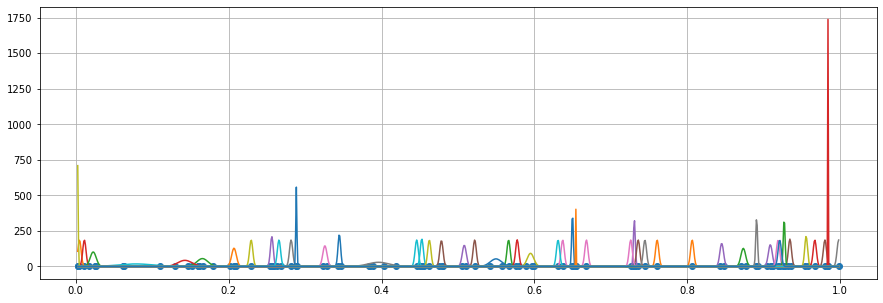

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, np.zeros_like(x), '-o')
v = np.linspace(x.min(), x.max(), 1000)
for i in range(k):
    ax.plot(v, stats.norm.pdf(v, loc=centers[i], scale=stds[i]))
ax.grid() ; plt.show() 

Observaţi cum apar mai multe gaussiene în zonele cu puncte mai dese. Încercaţi să modificaţi numărul de clustere.

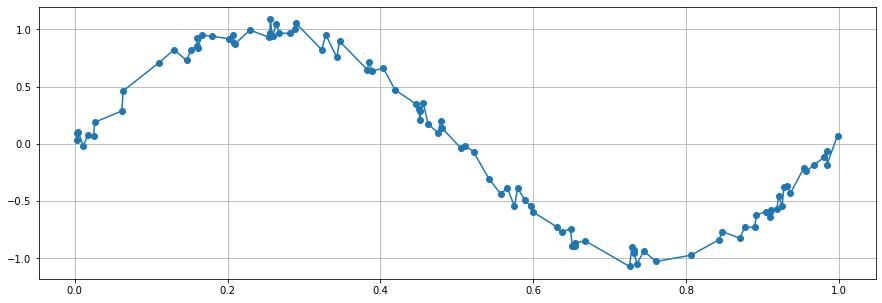

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

In [7]:
def rbf(x, c, sigma):
    return np.exp(- (x - c) ** 2 / (2 * sigma ** 2))

## Instruirea ponderilor stratului ascuns

Realizaţi, în fiecare epocă, parcurgerea sample cu sample. Pentru fiecare sample $x^{(i)}$ astfel ales, calculaţi valoarea activării (funcţia $f(\cdot)$), loss-ului şi a lui delta.

In [8]:
lr = 0.05
epochs = 200
w = np.random.randn(k)
b = np.random.randn(1)

for epoch in range(epochs):
    for i in range(len(x)):
        a = np.array([rbf(x[i], center, std) for center, std, in zip(centers, stds)])
        f = a.T @ w + b

        loss = (y[i] - f) ** 2 
        delta = y[i] - f 
        
        w += delta * lr * a
        b += delta * lr

Definiţi funcţia de inferenţă, de calcul a activării pentru fiecare element, $y\_pred^{(i)} = f(x^{(i)})$.

In [9]:
def inference(x):
    y_pred = []
    for i in range(x.size):
        a = np.array([rbf(x[i], center, std) for center, std, in zip(centers, stds)])
        f = a.T @ w + b
        y_pred.append(f)
    return np.array(y_pred)

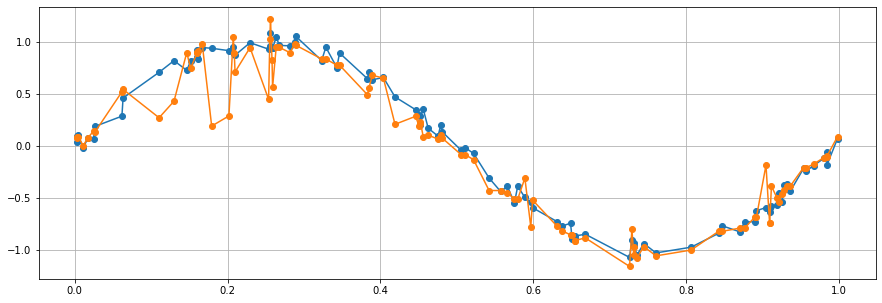

In [10]:
y_pred = inference(x)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.plot(x, y_pred, '-o')
ax.grid() ; plt.show() 

# Fine-tuning

Realizaţi:
* regularizarea ponderilor stratului ascuns
* modificaţi numărul de clustere K şi găsiţi cea mai bună valoare
* găsiţi cel mai bun parametru de regularizare şi cea mai bună rată de învăţare

## Implementare cu regularizare

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [12]:
class RBFNet(BaseEstimator, RegressorMixin):
    
    def __init__(self, k=2, lr=0.01, epochs=100, lmbda=0, rbf=rbf):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.lmbda = lmbda
        self.rbf = rbf
 
        self.w = np.random.randn(self.k)
        self.b = np.random.randn(1)
    
    def fit(self, x, y):
        
        self.centers, self.stds = kmeans(x, self.k)

        for epoch in range(self.epochs):
            for i in range(x.shape[0]):
                a = np.array([rbf(x[i], center, std) for center, std, in zip(self.centers, self.stds)])
                f = a.T @ self.w + self.b

                loss = (y[i] - f) ** 2 + self.lmbda * np.sum(self.w[1:] ** 2) 
                delta = y[i] - f + self.lmbda * 2 * np.sum(self.w[1:])
            
                self.w += delta * self.lr * a
                self.b += delta * self.lr
            
    def predict(self, x):
        y_pred = []
        for i in range(x.shape[0]):
            a = np.array([rbf(x[i], center, std) for center, std, in zip(self.centers, self.stds)])
            f = a.T @ self.w + self.b
            y_pred.append(f)
        return np.array(y_pred)

In [13]:
def plot(x, y, y_pred):
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.plot(x, y, '-o')
        ax.plot(x, y_pred, '-o')
        ax.grid() 
        plt.show() 

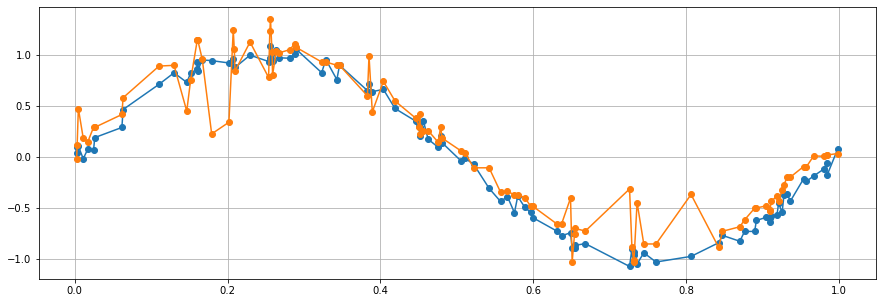

In [14]:
rbfnet = RBFNet(lr=0.02, epochs=200, k=50, lmbda=0.01)
rbfnet.fit(x, y)
 
y_pred = rbfnet.predict(x)

plot(x, y, y_pred)

In [15]:
rbfnet.score(x, y)

0.9100426704670959

## Cea mai bună valoare pentru k

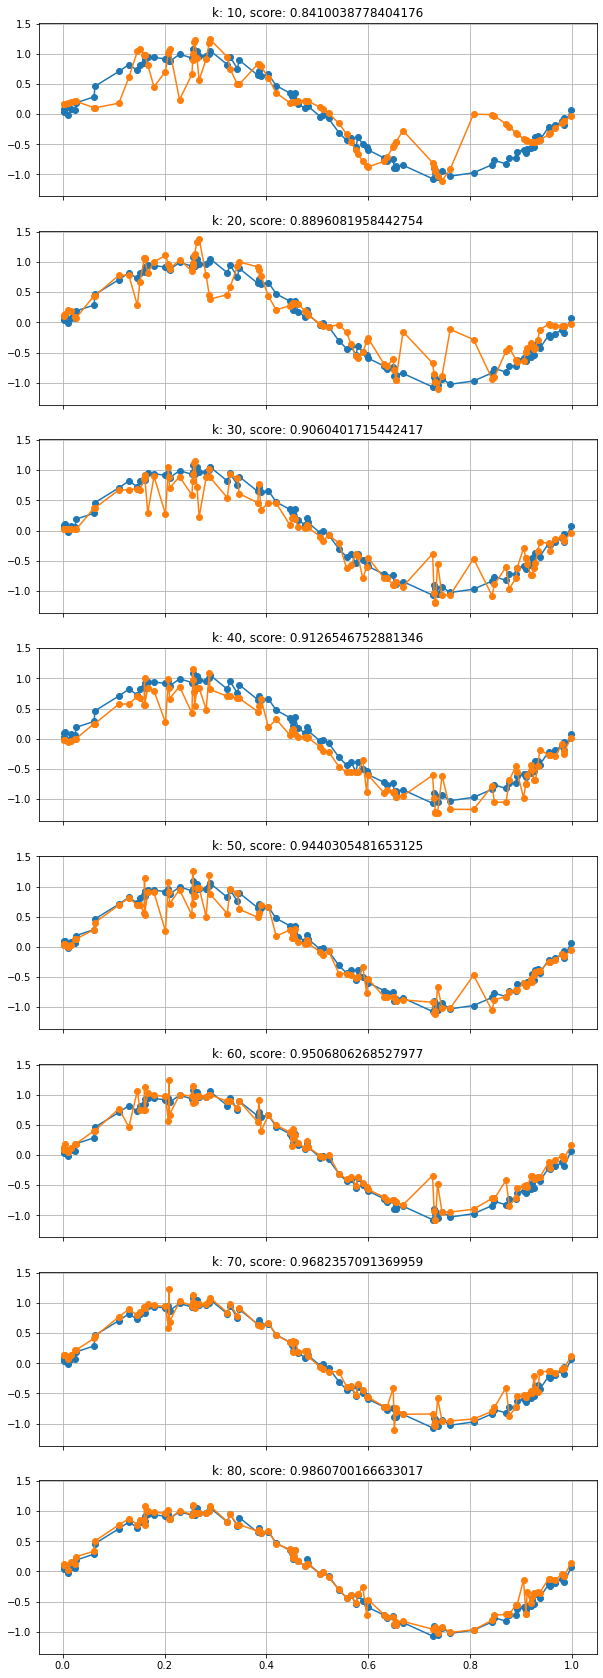

In [16]:
fig, ax = plt.subplots(nrows=8, sharex=True, sharey=True, figsize = (10, 30))
for i, k in enumerate(range(10, 90, 10), 0):
    rbfnet = RBFNet(lr=0.02, epochs=200, k=k, lmbda=0.01)
    rbfnet.fit(x, y)
    
    y_pred = rbfnet.predict(x)
    
    ax[i].plot(x, y, '-o')
    ax[i].plot(x, y_pred, '-o')
    ax[i].set_title(f'k: {k}, score: {rbfnet.score(x, y)}')
    ax[i].grid() 

Cea mai buna valoare: 80

## Cel mai bun parametru de regularizare şi cea mai bună rată de învăţare

In [17]:
parameter_grid = {'lr': [0.01, 0.02, 0.03],
                  'lmbda': [0.01, 0.02, 0.03] }

model = RBFNet(k=70, epochs=200)
grid_search = GridSearchCV(estimator=model, 
                           param_grid = parameter_grid, 
                           cv=5, n_jobs=-1)
    
grid_search.fit(x, y)
print(f"Best params: {grid_search.best_params_}")

Best params: {'lmbda': 0.01, 'lr': 0.03}


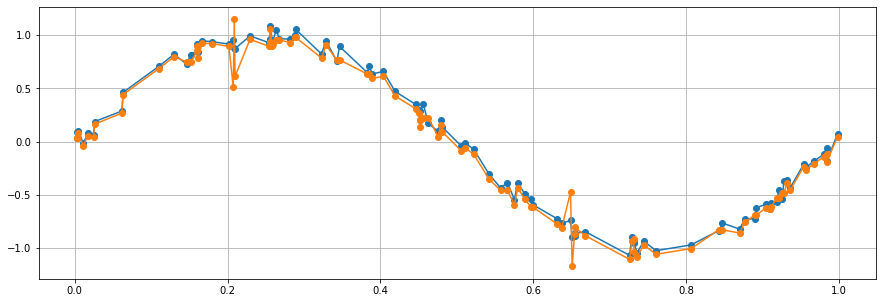

In [20]:
rbfnet = RBFNet(lr=0.03, epochs=200, k=80, lmbda=0.01)
rbfnet.fit(x, y)
 
y_pred = rbfnet.predict(x)

plot(x, y, y_pred)

In [21]:
rbfnet.score(x, y)

0.9849893638069419